In [1]:
import torch
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive
import numpy as np
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import gc
import seaborn as sns

from betavae import BVAE

/Users/thomas/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
model = torch.load('models/1-bvae-16dim')
model.eval()
z_dim = model.z_dim
shape_z = model.random_z

In [4]:
valid = torch.load('valid_shapes.pt')
valid_meta = pd.read_csv('valid_meta.csv')
valid_meta

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,rectangle,deep teal,0.000000,0.333333,0.352941,1.214666,0.598878,0.000000,0.000000,0.000000,37.041964,NaN,False
1,hexagon,burnt sienna,0.690196,0.305882,0.058824,1.000000,1.000000,0.000000,0.000000,28.106370,-7.332319,NaN,True
2,heptagon,dark sky blue,0.266667,0.556863,0.894118,1.145680,1.145680,241.684666,0.000000,0.000000,0.000000,NaN,False
3,octagon,seaweed,0.094118,0.819608,0.482353,1.000000,1.000000,0.000000,16.074111,0.000000,0.000000,NaN,False
4,octagon,pale teal,0.509804,0.796078,0.698039,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,.,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,triangle,greenish brown,0.411765,0.380392,0.070588,1.000000,1.000000,60.501415,0.000000,0.000000,8.650883,NaN,True
1996,triangle,baby blue,0.635294,0.811765,0.996078,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,False
1997,pentagon,dusky pink,0.800000,0.478431,0.545098,1.000000,1.000000,0.000000,0.000000,4.994519,0.000000,o,False
1998,triangle,leather,0.674510,0.454902,0.203922,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,False


In [5]:
valid_z = []
with torch.no_grad():
    for i in range(0, len(valid), 100):
        batch = valid[i:i+100].contiguous()
        _, _, _, z = model(batch)
        valid_z.append(z)
valid_z = torch.vstack(valid_z)
valid_z.shape

torch.Size([2000, 16])

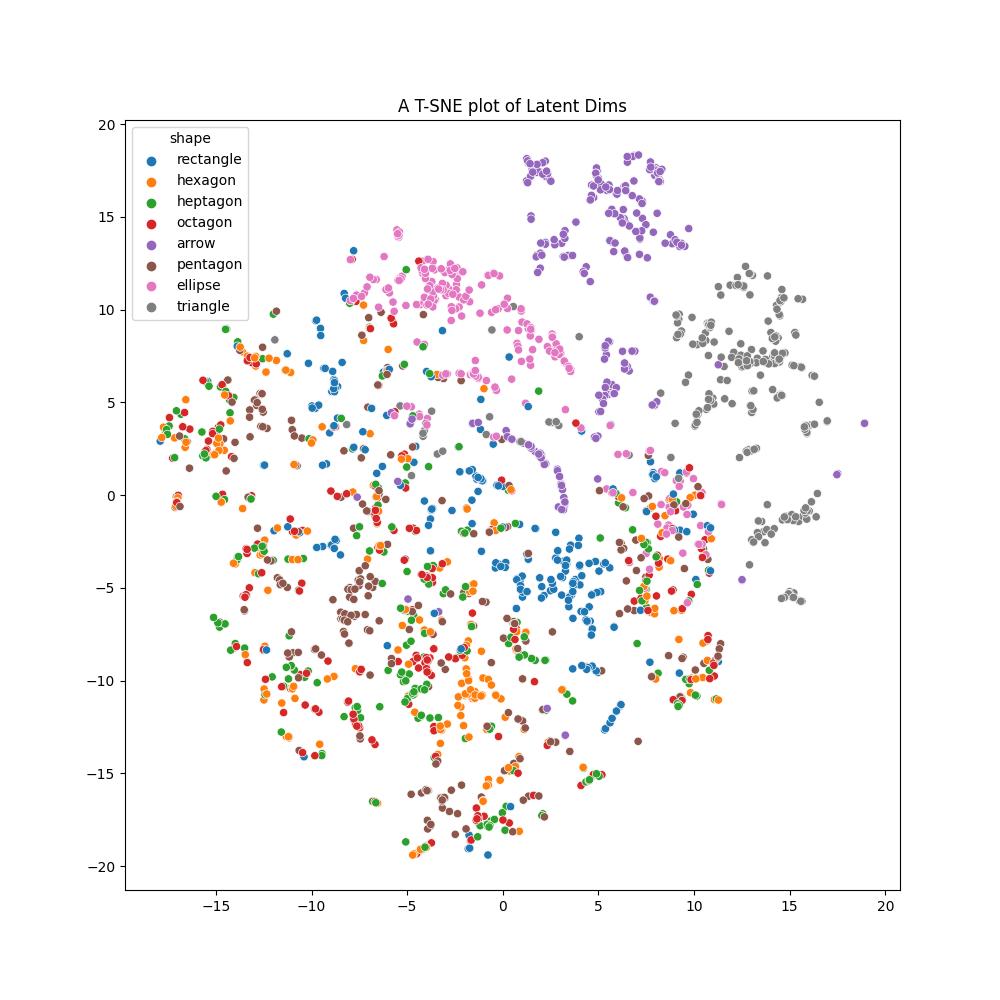

In [6]:
tsne = TSNE(n_components=2, n_iter=300)
tsne_results = tsne.fit_transform(valid_z)
plt.figure(figsize=(10,10))
color_dict = {
    color: 'xkcd:'+color
    for color in valid_meta.color
}
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=valid_meta['shape'],
#     hue=valid_meta.color,
#     palette=color_dict,
    legend="full"
).set(title='A T-SNE plot of Latent Dims');

In [7]:
z_slides = [
    widgets.FloatSlider(
    value=shape_z[i],
    min=-5,
    max=5,
    step=0.1,
    description=f'dim {i}',
    readout_format='.1f',
    orientation='vertical',
        continuous_update=False
    ) for i in range(z_dim)
]

dim_range_slider = widgets.FloatRangeSlider(
    value=[-4., 4.],
    min=-10., max=10., step=0.1,
    description='Range',
    readout_format='.1f',
        continuous_update=False
)
dim_select_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=z_dim-1,
    description='Latent Dim',
        continuous_update=False
)
num_im_slider = widgets.IntSlider(
    value=5,
    min=2,
    max=11,
    description='Num Images',
        continuous_update=False
)

tab1 = HBox(children=z_slides)
tab2 = VBox(children=[dim_select_slider, dim_range_slider, num_im_slider])
tab = widgets.Tab(children=[tab1, tab2])
tab.set_title(0, 'Initial Point')
tab.set_title(1, 'Vary Settings')
# VBox(children=[tab, widget])

def simple_plot(dim_range, dim_select, num_ims, **z_slides):
#     plt.close('all')
    
    with torch.no_grad():
        init_z = [z_slides[f'{i}'] for i in range(len(z_slides))]
        init_z = [init_z] * num_ims
        init_z = torch.Tensor(init_z)
        init_z[:, dim_select] += torch.linspace(*dim_range, num_ims)
        ims = model.to_img(init_z).permute(0, 2, 3, 1 ).cpu()
    
    fig, axes = plt.subplots(1, num_ims)
#     fig.suptitle(f'Varying  dim {dim_select} with {num_ims} images', y=0)
    fig.set_size_inches(10, 2)
    for i in range(num_ims):
        axes[i].imshow(ims[i])
        axes[i].set_title(f'dim {dim_select}={init_z[i, dim_select].item():.2f}')
    plt.show()

d = {'dim_range': dim_range_slider, 'dim_select':dim_select_slider, 'num_ims': num_im_slider,
     **{f'{i}':slide for i, slide in enumerate(z_slides)}}
out = widgets.interactive_output(simple_plot, d)

In [8]:
widgets.VBox([out, tab])